<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Segmentación de Clientes con Clustering Jerárquico y DBSCAN

El objetivo de este caso-taller es analizar una base de datos ficticia sobre clientes de una tienda y buscar encontrar grupos de clientes que permitan generar estrategias de marketing focalizadas. La base se encuentra en los `Archivos de Laboratorio` en la carpeta `data` y cuenta con 200 observaciones y 5 variables:

- `Id_Cliente`: identificador de cliente.
- `Genero`: género del cliente: Mujer, Hombre
- `Edad`: edad en años
- `Ingreso`: ingresos anuales
- `Puntaje_Gasto`: es una variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto.


## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1.Carga de datos

En la carpeta `data` se encuentra el archivo `datos_clientes.csv` cargue estos datos en su *cuaderno*.

In [15]:
!pip install kneed

In [16]:
!pip install scikit-learn-extra

In [17]:
!pip install gower

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import gower
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from kneed import KneeLocator

In [19]:
# Utilice este espacio para escribir el código.
datos = pd.read_csv('../data/datos_clientes.csv')
datos.head()

,Id_Cliente,Genero,Edad,Ingreso,Puntaje_Gasto
0,1,Mujer,41,98115.05,39
1,2,Mujer,20,35458.14,75
2,3,Mujer,68,59872.08,55
3,4,Hombre,63,48508.93,51
4,5,Mujer,31,44431.11,54


***Procedimiento***
____
Como primer paso se cargaron todas las librerias que se van a usar en el desarrollo del taller. Posterior a esto se llamó el archivo que contiene los datos y se visualizaron las primeras filas del mismo.

### 2. Análisis preliminar.

Antes de comenzar el análisis de segmentación utilice estadísticas descriptivas para explorar la variables que se encuentran en los datos. En su análisis mencione si hay patrones que surgen del examen descriptivo de los datos; entre ellos si hay diferencias en los ingresos y los puntajes de gastos para mujeres y hombres, por grupos etarios (18-24, 25-34, 35-44, 45-54, 55-64, y 65+), y por grupos etarios y género. Discuta además si estas diferencias son estadísticamente significativas.

In [20]:
## Crear la variable Grupo_Etario
Grupo_Etario = []
for i in datos.Edad:
  if i >= 18 and i <=24:
    Grupo_Etario.append('18-24')
  elif i >= 25 and i <=34:
    Grupo_Etario.append('25-34')
  elif i >= 35 and i <=44:
    Grupo_Etario.append('35-44')
  elif i >= 45 and i <=54:
    Grupo_Etario.append('45-54')
  elif i >= 55 and i <=64:
    Grupo_Etario.append('55-64')
  else:
    Grupo_Etario.append('65+')
datos['Grupo_Etario'] = Grupo_Etario
datos.head()

,Id_Cliente,Genero,Edad,Ingreso,Puntaje_Gasto,Grupo_Etario
0,1,Mujer,41,98115.05,39,35-44
1,2,Mujer,20,35458.14,75,18-24
2,3,Mujer,68,59872.08,55,65+
3,4,Hombre,63,48508.93,51,55-64
4,5,Mujer,31,44431.11,54,25-34


In [21]:
# Descripción de los datos
print(datos.describe())

       Id_Cliente        Edad        Ingreso  Puntaje_Gasto
count  200.000000  200.000000     200.000000     200.000000
mean   100.500000   38.850000   60624.446600      50.200000
std     57.879185   13.969007   26262.903416      25.823522
min      1.000000   18.000000   13458.020000       1.000000
25%     50.750000   28.750000   41512.787500      34.750000
50%    100.500000   36.000000   60777.960000      50.000000
75%    150.250000   49.000000   77143.865000      73.000000
max    200.000000   70.000000  138584.520000      99.000000


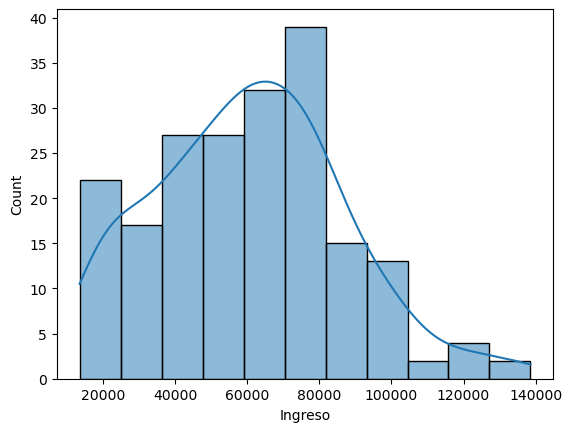

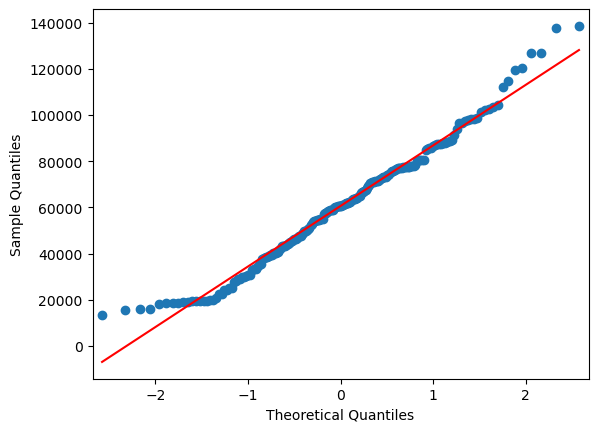

Estadístico de Shapiro-Wilk: 0.9788210123692573
p-value: 0.004060395890489644
La variable Ingreso NO sigue una distribución Normal


In [22]:
#### Analizar si la variable Ingresos sigue una distribución Normal

sns.histplot(data=datos, x='Ingreso', kde=True)  # Histograma con curva de densidad
sm.qqplot(datos['Ingreso'], line='s')  # Gráfico Q-Q
plt.show()

# Prueba de Shapiro-Wilk
stat, p = stats.shapiro(datos['Ingreso'])
print('Estadístico de Shapiro-Wilk:', stat)
print('p-value:', p)

print("La variable Ingreso NO sigue una distribución Normal")

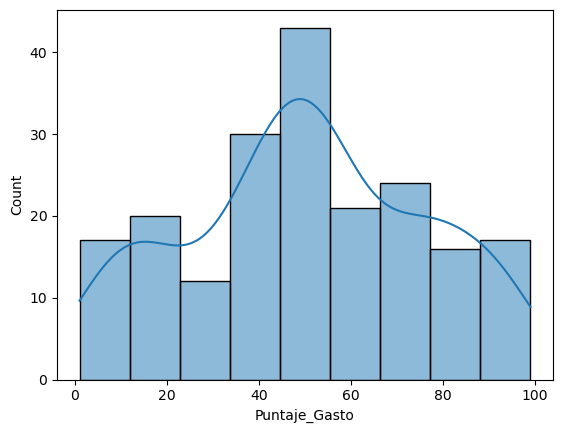

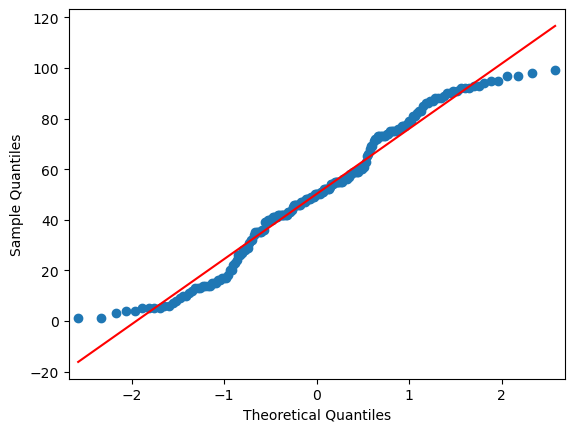

Estadístico de Shapiro-Wilk: 0.9694606767011337
p-value: 0.00024229713933301153
La variable Puntaje_Gasto NO sigue una distribución Normal


In [23]:
#### Analizar si la variable Puntaje_Gastos sigue una distribución Normal

sns.histplot(data=datos, x='Puntaje_Gasto', kde=True)  # Histograma con curva de densidad
sm.qqplot(datos['Puntaje_Gasto'], line='s')  # Gráfico Q-Q
plt.show()

# Prueba de Shapiro-Wilk
stat, p = stats.shapiro(datos['Puntaje_Gasto'])
print('Estadístico de Shapiro-Wilk:', stat)
print('p-value:', p)

print("La variable Puntaje_Gasto NO sigue una distribución Normal")

       Id_Cliente                                                           \
            count        mean        std  min    25%    50%     75%    max   
Genero                                                                       
Hombre       88.0  103.318182  57.000211  4.0  59.75  107.5  152.25  198.0   
Mujer       112.0   98.285714  58.720352  1.0  46.75   94.5  149.25  200.0   

         Edad             ...     Ingreso            Puntaje_Gasto             \
        count       mean  ...         75%        max         count       mean   
Genero                    ...                                                   
Hombre   88.0  39.806818  ...  77731.3025  138584.52          88.0  48.511364   
Mujer   112.0  38.098214  ...  76788.3875  126685.78         112.0  51.526786   

                                               
             std  min   25%   50%   75%   max  
Genero                                         
Hombre  27.89677  1.0  24.5  50.0  70.0  97.0  
Mujer   24.

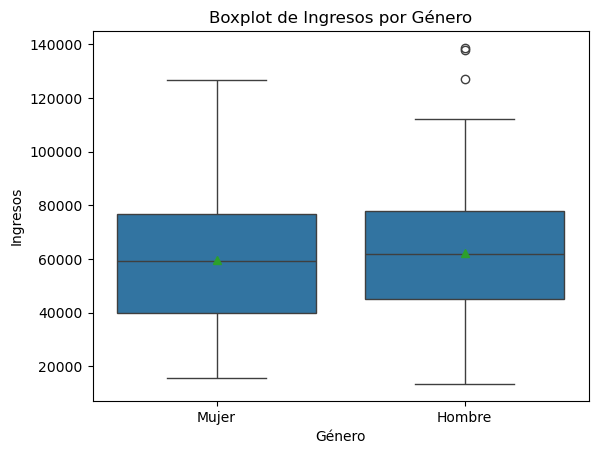

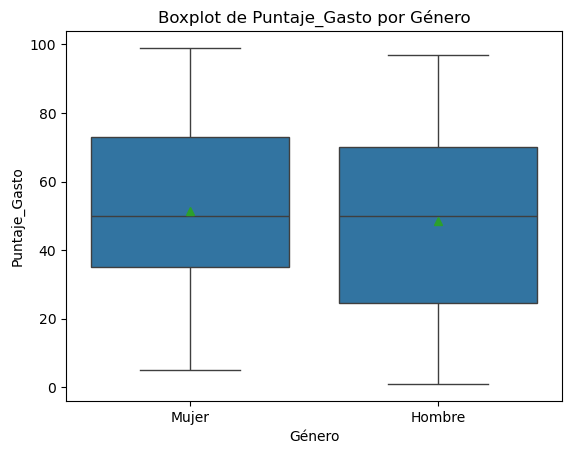

Ingresos
Estadístico de Mann-Whitney: 5228.0
p-value: 0.4610484707692625
Puntaje_Gasto
Estadístico de Mann-Whitney: 4697.5
p-value: 0.5712794188160656


In [24]:
print(datos.groupby(['Genero']).describe())

# Boxplot
sns.boxplot(x='Genero', y='Ingreso', data=datos,showmeans=True)
plt.title('Boxplot de Ingresos por Género')
plt.xlabel('Género')
plt.ylabel('Ingresos')
plt.show()


sns.boxplot(x='Genero', y='Puntaje_Gasto', data=datos,showmeans=True)
plt.title('Boxplot de Puntaje_Gasto por Género')
plt.xlabel('Género')
plt.ylabel('Puntaje_Gasto')
plt.show()

## Prueba estadística de comparación de grupos
stat, p = mannwhitneyu(datos[datos['Genero'] == 'Hombre']['Ingreso'], datos[datos['Genero'] == 'Mujer']['Ingreso'])
print('Ingresos')
print('Estadístico de Mann-Whitney:', stat)
print('p-value:', p)

stat, p = mannwhitneyu(datos[datos['Genero'] == 'Hombre']['Puntaje_Gasto'], datos[datos['Genero'] == 'Mujer']['Puntaje_Gasto'])
print('Puntaje_Gasto')
print('Estadístico de Mann-Whitney:', stat)
print('p-value:', p)

             Id_Cliente                                                     \
                  count        mean        std   min    25%    50%     75%   
Grupo_Etario                                                                 
18-24              35.0   98.200000  60.634294   2.0  42.00  102.0  148.50   
25-34              54.0   99.648148  62.419505   5.0  49.25   91.0  156.75   
35-44              42.0  107.714286  60.680003   1.0  52.50  119.5  154.75   
45-54              39.0  103.974359  50.441987  26.0  66.50  103.0  143.50   
55-64              16.0   80.812500  47.866786   4.0  54.25   83.0  108.50   
65+                14.0  100.714286  58.208417   3.0  72.00  102.0  141.00   

                     Edad             ...     Ingreso             \
                max count       mean  ...         75%        max   
Grupo_Etario                          ...                          
18-24         199.0  35.0  20.828571  ...  61564.3550   80360.65   
25-34         196.0  54.0

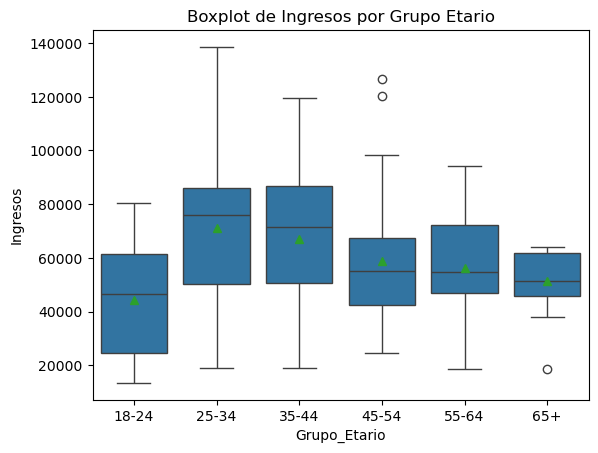

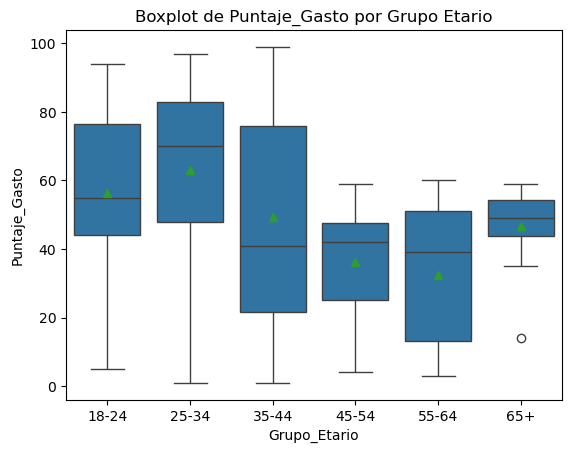

Ingresos
Estadístico de Kruskal-Wallis: 28.6210656197037
p-value: 2.7513407092153548e-05
Puntaje_Gasto
Estadístico de Kruskal-Wallis: 35.33580745995885
p-value: 1.2894171615973073e-06


In [25]:
print(datos.groupby(['Grupo_Etario']).describe())


# Boxplot
# Orden deseado de las categorías
orden_categorias = ['18-24', '25-34', '35-44','45-54','55-64','65+']
sns.boxplot(x='Grupo_Etario', y='Ingreso', data=datos, order=orden_categorias,showmeans=True)
plt.title('Boxplot de Ingresos por Grupo Etario')
plt.xlabel('Grupo_Etario')
plt.ylabel('Ingresos')
plt.show()

sns.boxplot(x='Grupo_Etario', y='Puntaje_Gasto', data=datos, order=orden_categorias,showmeans=True)
plt.title('Boxplot de Puntaje_Gasto por Grupo Etario')
plt.xlabel('Grupo_Etario')
plt.ylabel('Puntaje_Gasto')
plt.show()

## Prueba estadística de comparación de grupos
stat, p = kruskal(datos[datos['Grupo_Etario'] == '18-24']['Ingreso'],datos[datos['Grupo_Etario'] == '25-34']['Ingreso'], datos[datos['Grupo_Etario']=='35-44']['Ingreso'],datos[datos['Grupo_Etario']=='45-54']['Ingreso'],datos[datos['Grupo_Etario']=='55-64']['Ingreso'],datos[datos['Grupo_Etario']=='65+']['Ingreso'])
print('Ingresos')
print('Estadístico de Kruskal-Wallis:', stat)
print('p-value:', p)

stat, p = kruskal(datos[datos['Grupo_Etario'] == '18-24']['Puntaje_Gasto'],datos[datos['Grupo_Etario'] == '25-34']['Puntaje_Gasto'], datos[datos['Grupo_Etario']=='35-44']['Puntaje_Gasto'],datos[datos['Grupo_Etario']=='45-54']['Puntaje_Gasto'],datos[datos['Grupo_Etario']=='55-64']['Puntaje_Gasto'],datos[datos['Grupo_Etario']=='65+']['Puntaje_Gasto'])
print('Puntaje_Gasto')
print('Estadístico de Kruskal-Wallis:', stat)
print('p-value:', p)



                    Id_Cliente                                              \
                         count        mean        std   min     25%    50%   
Grupo_Etario Genero                                                          
18-24        Hombre       16.0  106.312500  57.711603   8.0   68.25  104.0   
             Mujer        19.0   91.368421  63.727903   2.0   37.50  102.0   
25-34        Hombre       22.0   84.454545  54.622276   6.0   43.25   74.0   
             Mujer        32.0  110.093750  66.057824   5.0   49.75   98.0   
35-44        Hombre       18.0  125.000000  59.572990  16.0   69.50  149.5   
             Mujer        24.0   94.750000  59.424962   1.0   41.50  114.0   
45-54        Hombre       14.0  128.642857  45.569232  26.0  105.25  136.0   
             Mujer        25.0   90.160000  48.477383  30.0   46.00   80.0   
55-64        Hombre        9.0   65.333333  49.934958   4.0   19.00   74.0   
             Mujer         7.0  100.714286  39.773166  63.0   74

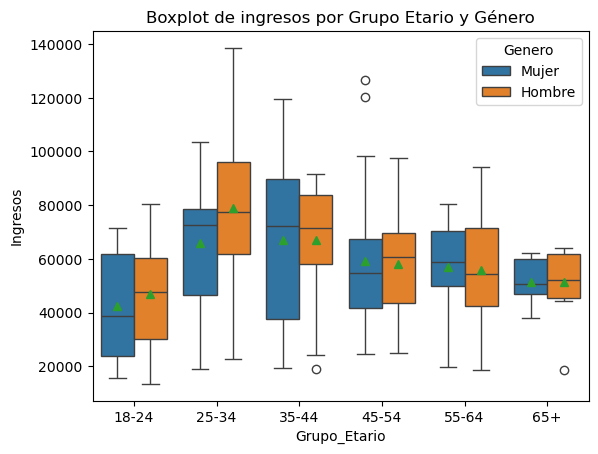

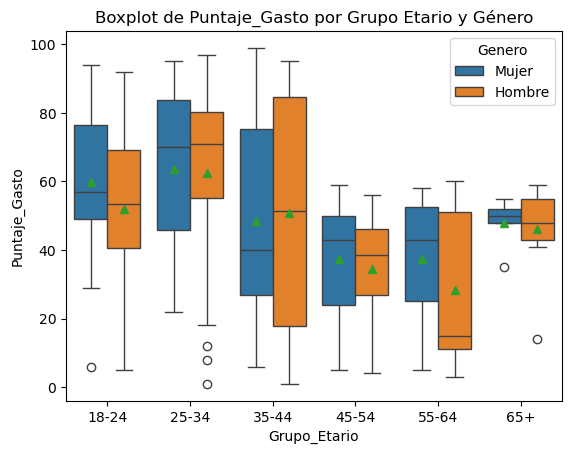

Ingresos
Estadístico de Kruskal-Wallis: 30.782240586314288
p-value: 0.0011927204920744463
Puntaje_Gasto
Estadístico de Kruskal-Wallis: 37.085730184248625
p-value: 0.00011148174798330127


In [26]:
print(datos.groupby(['Grupo_Etario', 'Genero']).describe())

# Boxplot
orden_categorias = ['18-24', '25-34', '35-44','45-54','55-64','65+']
sns.boxplot(x='Grupo_Etario', y='Ingreso', hue='Genero', data=datos, order=orden_categorias,showmeans=True)
plt.title('Boxplot de ingresos por Grupo Etario y Género')
plt.xlabel('Grupo_Etario')
plt.ylabel('Ingresos')
plt.show()

sns.boxplot(x='Grupo_Etario', y='Puntaje_Gasto', hue='Genero', data=datos, order=orden_categorias,showmeans=True)
plt.title('Boxplot de Puntaje_Gasto por Grupo Etario y Género')
plt.xlabel('Grupo_Etario')
plt.ylabel('Puntaje_Gasto')
plt.show()

## Prueba estadística de comparación de grupos
stat, p = kruskal(datos[(datos['Grupo_Etario'] == '18-24') & (datos['Genero']=='Mujer')]['Ingreso'],datos[(datos['Grupo_Etario'] == '18-24') & (datos['Genero']=='Hombre')]['Ingreso'],datos[(datos['Grupo_Etario'] == '25-34') & (datos['Genero']=='Mujer')]['Ingreso'],datos[(datos['Grupo_Etario'] == '25-34') & (datos['Genero']=='Hombre')]['Ingreso'],datos[(datos['Grupo_Etario'] == '35-44') & (datos['Genero']=='Mujer')]['Ingreso'],datos[(datos['Grupo_Etario'] == '35-44') & (datos['Genero']=='Hombre')]['Ingreso'],datos[(datos['Grupo_Etario'] == '45-54') & (datos['Genero']=='Mujer')]['Ingreso'],datos[(datos['Grupo_Etario'] == '45-54') & (datos['Genero']=='Hombre')]['Ingreso'],datos[(datos['Grupo_Etario'] == '55-64') & (datos['Genero']=='Mujer')]['Ingreso'],datos[(datos['Grupo_Etario'] == '55-64') & (datos['Genero']=='Hombre')]['Ingreso'],datos[(datos['Grupo_Etario'] == '65+') & (datos['Genero']=='Mujer')]['Ingreso'],datos[(datos['Grupo_Etario'] == '65+') & (datos['Genero']=='Hombre')]['Ingreso'])
print('Ingresos')
print('Estadístico de Kruskal-Wallis:', stat)
print('p-value:', p)


stat, p = kruskal(datos[(datos['Grupo_Etario'] == '18-24') & (datos['Genero']=='Mujer')]['Puntaje_Gasto'],datos[(datos['Grupo_Etario'] == '18-24') & (datos['Genero']=='Hombre')]['Puntaje_Gasto'],datos[(datos['Grupo_Etario'] == '25-34') & (datos['Genero']=='Mujer')]['Puntaje_Gasto'],datos[(datos['Grupo_Etario'] == '25-34') & (datos['Genero']=='Hombre')]['Puntaje_Gasto'],datos[(datos['Grupo_Etario'] == '35-44') & (datos['Genero']=='Mujer')]['Puntaje_Gasto'],datos[(datos['Grupo_Etario'] == '35-44') & (datos['Genero']=='Hombre')]['Puntaje_Gasto'],datos[(datos['Grupo_Etario'] == '45-54') & (datos['Genero']=='Mujer')]['Puntaje_Gasto'],datos[(datos['Grupo_Etario'] == '45-54') & (datos['Genero']=='Hombre')]['Puntaje_Gasto'],datos[(datos['Grupo_Etario'] == '55-64') & (datos['Genero']=='Mujer')]['Puntaje_Gasto'],datos[(datos['Grupo_Etario'] == '55-64') & (datos['Genero']=='Hombre')]['Puntaje_Gasto'],datos[(datos['Grupo_Etario'] == '65+') & (datos['Genero']=='Mujer')]['Puntaje_Gasto'],datos[(datos['Grupo_Etario'] == '65+') & (datos['Genero']=='Hombre')]['Puntaje_Gasto'])
print('Puntaje_Gasto')
print('Estadístico de Kruskal-Wallis:', stat)
print('p-value:', p)

***Procedimiento***
___
Como primer paso se generó un ciclo con condicionales para crear la variable Grupo_Etario, la cuál se incluyó posteriormente a los datos. Posteriomente se uso la función .describe() para visualizar la información general de cada una de las variables.
Para el análisis de diferencias entre grupos, primero se verificó si la variable Ingresos y las variable Puntaje_Gasto seguían una distribución normal, empleando salidas graficas y la prueba de Shapiro-Wilk, dado que no se cumple el supuesto de normalidad, se emplearon las pruebas NO parámetricas de Mann-Whitney para comparar diferencias entre las medianas de dos grupos y de Kruskal-Wallis para comparar diferencias entre varios grupos. Por último, para comparar las diferencias entre grupos, se generar las tablas de resumen y se realizaron boxplot de las variables Ingresos y Puntaje_Gastos diferenciado por grupos.


***Análisis y Conclusiones***
___
La base de datos cuenta con 200 registros y 5 variables, que son:
* Id_Cliente: un identificador del cliente
* Edad: variable númerica, que toma valores entre 18 y 70, con un valor promedio de 39 +- 14.
* Ingreso: Variable númerica, que toma valores entre 13458,02 y 138584,52, con un valor promedio de 60624,45 +- 26262,9.
* Puntaje_Gasto: variable númerica, que toma valores entre 1 y 99, con un promedio de 50 +- 26.
* Género: variable categorica, con dos factores "Hombre" y "Mujer."

A un nivel de confianza del 95 % existe evidencia estadísticamente significativa para rechazar la hiótesis de que las variables Ingresos y Puntaje_Gasto siguen una distribución normal, lo cual se puede osbervar también en los Q-Q plot y en los histogramas.

**Diferencias por género**

Como se observa en los boxplot, los rangos de variación y el promedio tanto de Ingresos como del Puntaje_Gasto es muy similar entre hombres y mujeres, lo cual se ve reflejado en los resultados se la prueba de Mann-Whitnet, con la cual se determinó que a un nivel de confianza del 95 % NO existe evidencia estadísticamente significativa para rechar la hipótesis de que la mediana de los Ingresos y del Puntaje_Gastos es igual entre hombres y mujeres.


**Diferencias por grupo etario**

Al analizar los ingresos y el Puntaje_Gastos por grupos etarios, se observa que existen diferencias marcadas entre algunos de los grupos. Para la variable Ingresos se observa que los valores más bajos se presentan en el grupo "18-24" lo cual puede estar relacionado con que son personas que están apenas inciando su vida labora, posteriormente los grupos entre "25-34" y "35-44" presentan promedios y rangos de variación cercanos, siendo los ingresos más altos. Luego los ingresos disminuyen y presentan un valor promedio similar en los grupos de "45-54", "55-64" y "65+", sin embargo, se observa que la variación en este último grupo es mucho menor y que los ingresos tienen a tener un comportamiento más homogéneo, lo cuál puede estar relacionado con la edad de jubilación y el ingreso constante de la misma. En cuanto al Puntaje_Gasto se observan amplios intervalos de variación en los tres primeros grupos etarios, siendo el grupo "25-34" el que presenta los valores más altos en promedio cercano a 70, para los tres grupos de más edad este intervalo de variación es menor, los valores máximos se encuetran incluso por debajo del 50 % de los datos de los dos primeros grupos y el valor promedio es cercano a 40, por último, al igual que en la variable Ingresos, el grupo "65+" es el que presenta menos variación en sus valores. Estas diferencias se ven reflejadas en la prueba de comparación de medianas de Kruskal-Wallis mediante la cual se puede determinar que a un nivel de confianza del 95 % existe evidencia extadísticamente signifiativa para rechazar las hipotesis de que las medianas de la variable Ingresos y la variable Puntaje_Gastos son iguales para todos los grupos etarios.


**Diferencias por grupo Etario y Género***

Al analizar los ingresos y el Puntaje_Gastos por grupos etarios y género, se observa que existen diferencias marcadas entre algunos de los grupos principalmente asociadas al grupo etario. Para la variable Ingresos, además de las diferencias marcadas por grupo etario mencionadas en el numeral anterior, se observa que para el rango entre "25-34" los ingresos de las mujeres tienden a ser más altos que los de los hombres, mientras que para los demás rangos los valores son bastante cercanos.  En cuanto a la variable Puntaje_Gasto, además de las diferencias por grupo etario ya mencionadas, se observa que en los rangos de edad de "18-24" y "55-64" los valores para las mujeres tienden a ser menores que los de los hombres, para los demás grupos etarios el comportamiento es bastante similar entre ambos géneros. Estas diferencias se ven reflejadas en la prueba de comparación de medianas de Kruskal-Wallis mediante la cual se puede determinar que a un nivel de confianza del 95 % existe evidencia extadísticamente signifiativa para rechazar las hipotesis de que las medianas de la variable Ingresos y la variable Puntaje_Gastos son iguales para todos los grupos etarios por género.






### 3. Clustering Jerárquico

#### 3.1. Dendrogramas

Agrupe a los clientes utilizando sólo dos variables: su ingreso y el puntaje de gastos. Para ello retenga estas dos variables, estandarízelas, construya y grafique un dendograma. Para la construcción del dendrograma utilice el enlace 'ward' y la distancia euclidiana. Explique la importancia de estandarizar los datos.

In [27]:
# Utilice este espacio para escribir el código.
## Retener las variables
datos_retenidos = datos[['Ingreso','Puntaje_Gasto']]
print(datos_retenidos.head())
## Estandarización de las variables
scaler = StandardScaler()
datos_estandarizados = scaler.fit_transform(datos_retenidos)
datos_estandarizados = pd.DataFrame(datos_estandarizados, columns=datos_retenidos.columns)
print(datos_estandarizados.head())

    Ingreso  Puntaje_Gasto
0  98115.05             39
1  35458.14             75
2  59872.08             55
3  48508.93             51
4  44431.11             54
    Ingreso  Puntaje_Gasto
0  1.431094      -0.434801
1 -0.960650       0.962775
2 -0.028719       0.186343
3 -0.462474       0.031057
4 -0.618133       0.147522


In [28]:
## Calculo de la matriz de distancias
Z = linkage(datos_estandarizados, method='ward',metric='euclidean')

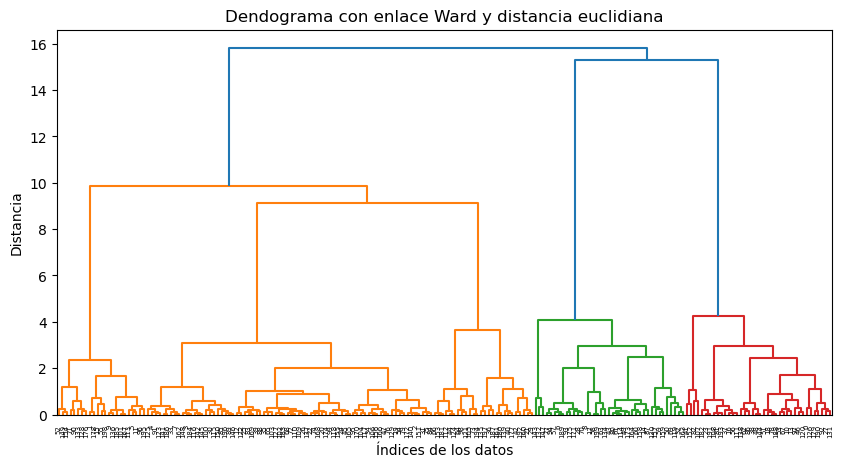

In [29]:
# Crear el dendograma
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Dendograma con enlace Ward y distancia euclidiana')
plt.xlabel('Índices de los datos')
plt.ylabel('Distancia')
plt.show()

***Procedimiento***

Como primer paso, se creó un dataset que contiene únicamente las variables Ingreso y Puntaje_Gasto, posteriormente se estandarizarone estas variables ya que presentan escalas muy diferentes. Posterior a esto, se calculó la matriz de distancias empleando el enlace 'ward' y la distancia euclidiana. Por último, se graficó el dendograma a partir de la matriz de distancias.

***Análisis y conclusiones***

Con una máxima de distancia de 10, se puede observar que se forman 3 clusters, sin embargo, se observa que en el primero de ellos (naranja) se puede estar perdiendo información valiosa de grupos más pequeños que se forman a una menor distancia.

#### 3.2. Número de clusters

Retenga el número de clusters que se obtengan luego de fijar la distancia en 6.

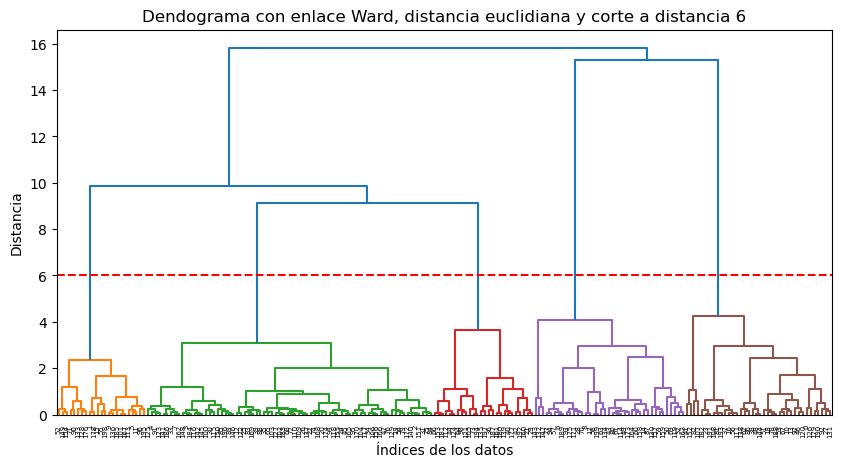

In [30]:
# Fijar la distancia en 6 y obtener los índices de los clusters
max_dist = 6
clusters = fcluster(Z, max_dist, criterion='distance')

# Visualizar los clusters
plt.figure(figsize=(10, 5))
dendrogram(Z, color_threshold=max_dist)
plt.title('Dendograma con enlace Ward, distancia euclidiana y corte a distancia 6')
plt.xlabel('Índices de los datos')
plt.ylabel('Distancia')
plt.axhline(y=max_dist, color='r', linestyle='--')  # Línea horizontal para indicar el corte
plt.show()

***Procedimiento***

Se empleó la matriz de distancias caculada en el punto anterior y se determinaron los clusters fijando la máxima distancia en 6. Posterior a esto se grafico el dendograma resultante.

***Análisis y conclusiones***

Al establecer la máxima distancia en 6, se puede observar como el cluster grande que se formaba en el punto anterior, se dividide en 3 cluster, generando así un total de 5 agrupaciones.

#### 3.3. Algoritmo Jerárquico Aglomerativo

Utilizando el número de clusters encontrados en el paso anterior, aplique el algoritmo jerárquico aglomerativo, utilizando el enlace 'ward' y la distancia euclidiana. Describa los grupos encontrados, en que grupo o grupos concentraría su estrategia de marketing y por qué?

In [31]:
# Asignar los puntos a los clusters
num_clusters = 5
labels = fcluster(Z, num_clusters, criterion='maxclust')

# Agregar los labels de los clusters al DataFrame
datos['cluster'] = labels

# Mostrar los primeros registros
print(datos.head())

   Id_Cliente  Genero  Edad   Ingreso  Puntaje_Gasto Grupo_Etario  cluster
0           1   Mujer    41  98115.05             39        35-44        5
1           2   Mujer    20  35458.14             75        18-24        1
2           3   Mujer    68  59872.08             55          65+        2
3           4  Hombre    63  48508.93             51        55-64        2
4           5   Mujer    31  44431.11             54        25-34        2


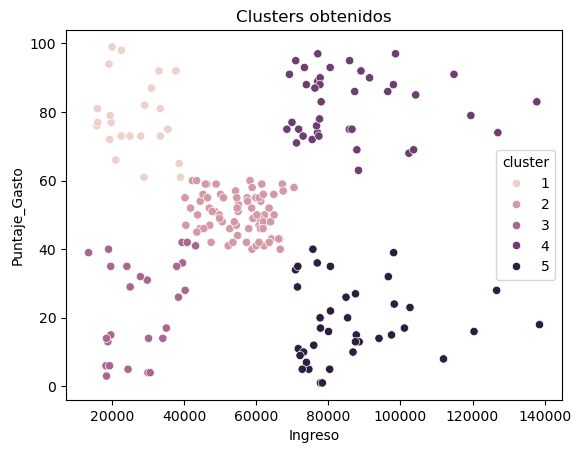

In [32]:
## Grafico de los clusters
sns.scatterplot(x='Ingreso', y='Puntaje_Gasto', hue='cluster', data=datos)
plt.title('Clusters obtenidos')
plt.show()

***Procedimiento***

Se fijó el número máximo de clusters en 5 que fue el valor que se obtuvo con una distancia máxima de 6, posteriormente se agrego la variable cluster asignando a cada observación el número correspodniente y por último se graficó los Ingreso Vs el Puntaje_Gasto diferenciado cada cluster por color.


***Análisis y conclusiones***

Según los resultados obtenidos concentraría la estrategia de Marketing en dos grupos en particular, primero en grupo "5" que corresponde a personas con Ingresos altos pero muy bajo Puntaje de Gasto y después en el grupo "3" que corresponde a personas con Ingresos Medios y Puntaje de Gasto Medio, esto con el fin de atraerlos y motivarlos a comprar más. Por otra parte, los grupos "1" y "4" son grupos de clientes que es importante fidelizar y mantener en la compañia, ya que son los que presentan el puntaje de gasto más alto.

### 4. DBSCAN

Implemente DBSCAN, al igual que el punto anterior sólo dos variables: su ingreso y el puntaje de gastos. Al implementar  justifique su elección de `min_samples` y `eps`. ¿Cuántos grupos o clusters encuentra? ¿Cuáles son su características? ¿Cambiaría su estrategia de marketing respecto al punto anterior? Justifique su respuesta.

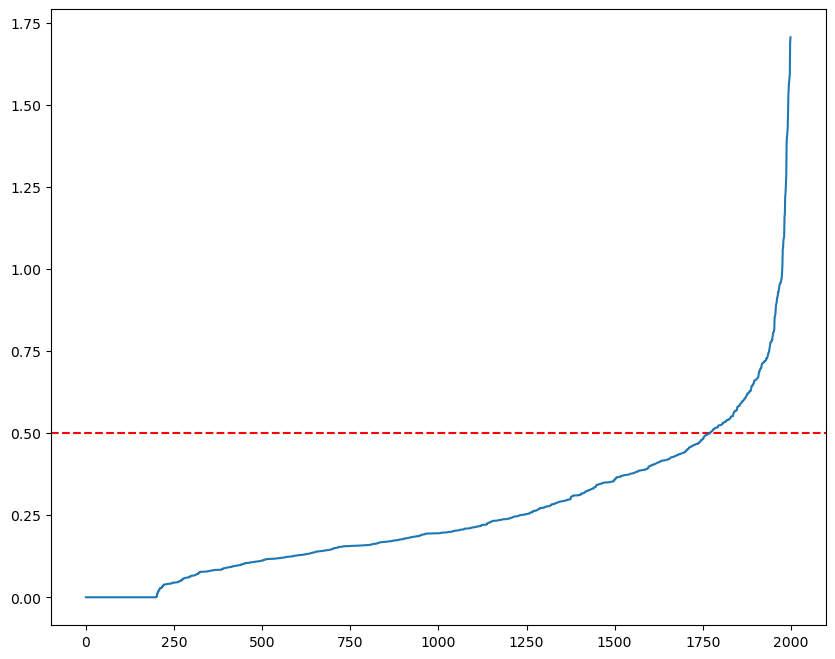

In [33]:
# Cargamos NeighborsNeighbors
neigh = NearestNeighbors(n_neighbors = 10)
nbrs = neigh.fit(datos_estandarizados)
distancias, indices = nbrs.kneighbors(datos_estandarizados)
distancias = np.sort(distancias.flatten())
fig=plt.figure(figsize=(10,8), dpi= 100, facecolor='w', edgecolor='k')
plt.axhline(y = 0.50, color = 'r', linestyle = '--')
plt.plot(distancias)

In [34]:
i = np.arange(len(distancias))
knee = KneeLocator(i, distancias, S=1, curve='convex', direction='increasing', interp_method='polynomial')

print(distancias[knee.knee])

0.4934968313866966


In [35]:
# Crear un modelo DBSCAN
db = DBSCAN(eps=0.49, min_samples=12)
clusters=db.fit_predict(datos_estandarizados)

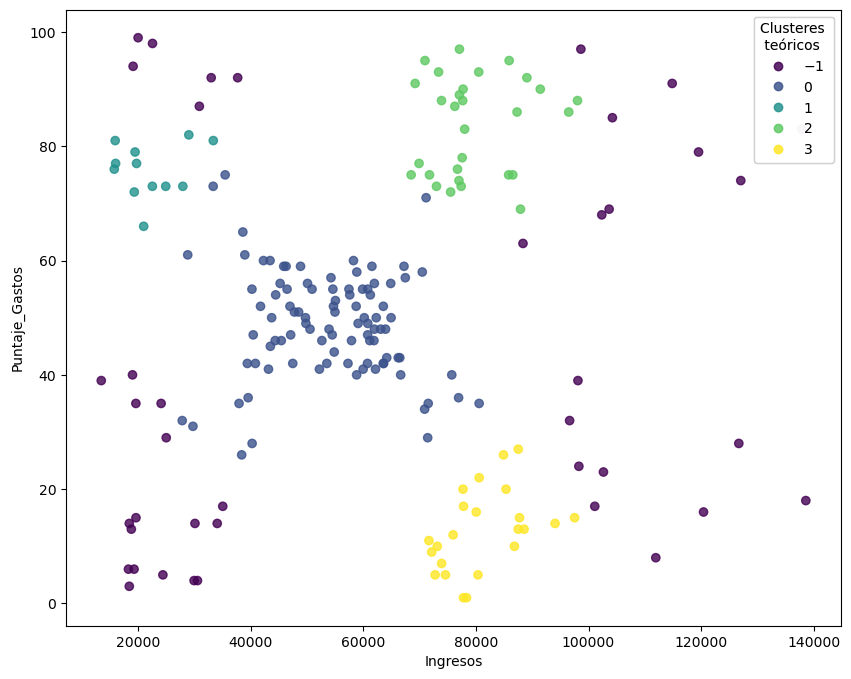

In [36]:
fig, ax = plt.subplots(figsize=(10,8), dpi= 100, facecolor='w', edgecolor='k')
# Access DataFrame columns using their names or the .iloc method
g = plt.scatter(datos_retenidos.iloc[:,0], datos_retenidos.iloc[:,1], c = clusters, alpha = 0.8)
legend = ax.legend(*g.legend_elements(), loc = "upper right", title = "Clusteres \n teóricos")
ax.add_artist(legend)
plt.xlabel('Ingresos')
plt.ylabel('Puntaje_Gastos')
plt.show()

***Procedimiento***

Como primer paso se realizó la gráfica propuesta por Rahmah y Sukaesih (2012) para encontrar la mejor eps, calculando la distancia desde cada punto a su vecino más cercano usando NeighborsNeighbors y un número de vecinos igual a 10, psoteriormente se empleó la librería kneed para determinar el punto de máxima curbatura con mayor exactitud. Para el número de dimensiones, primero se analizó el criterio de Ester et al. (1996) para datos con dos dimensiones, min_samples=4, sin embargo, se observó que con este valor la agrupación no era buena, por lo tanto, y teniendo en cuenta que la cantidad de observaciones alta, se probaon diferentes opciones y se cambió el número de min_samples a 12. Se generó el modelo DBSCAN y se graficaron los resultados, diferenciando cada cluster con un color. Todo el análisis se realizó con los datos previamente estandarizados.

***Análisis y conclusiones***

Se determinó que para los datos estandarizados la mejor eps era de 0,49, mientras que para el número mínimo de muestras se encontró que con 4 el ajuste era muy pobre y se generaba un solo cluster, los mejores resultados se encontraton emplando un número mínimo de muestras de 12, sin embargo, se observa que esta diferenciación no es muy buena y que no se logran agrupar los datos que corresponden a Ingresos y Puntaje_Gasto bajo, además de que muchos de los datos se clasifican como atipicos. Por lo cuál se considera que se obtuvo una mejor agrupación con el método anterior.

### 5. Incorporando más dimensiones

Hasta este momento hemos utilizado solo dos variables para nuestro análisis, sin embargo, la base cuenta con otras variables más: género y edad. Usando las categorías de edad creadas anteriormente incorpore género y grupo etario a su análisis. Genere los grupos utilizando DBSCAN y la distancia de Gower, justificando su elección de `min_samples` y `eps`   ¿Incorporar estas variables, ayuda a la focalización de la estrategia de marketing?

In [37]:
## Retener las variables
datos_retenidos2 = datos[['Ingreso','Puntaje_Gasto','Genero','Grupo_Etario']]
print(datos_retenidos2.head())

## Estandarización de las variables
datos_estandarizados2 = datos_estandarizados.copy()
datos_estandarizados2['Genero'] = datos['Genero']
datos_estandarizados2['Grupo_Etario'] = datos['Grupo_Etario']
print(datos_estandarizados2.head())

    Ingreso  Puntaje_Gasto  Genero Grupo_Etario
0  98115.05             39   Mujer        35-44
1  35458.14             75   Mujer        18-24
2  59872.08             55   Mujer          65+
3  48508.93             51  Hombre        55-64
4  44431.11             54   Mujer        25-34
    Ingreso  Puntaje_Gasto  Genero Grupo_Etario
0  1.431094      -0.434801   Mujer        35-44
1 -0.960650       0.962775   Mujer        18-24
2 -0.028719       0.186343   Mujer          65+
3 -0.462474       0.031057  Hombre        55-64
4 -0.618133       0.147522   Mujer        25-34


In [38]:
# Codificar las variables categóricas
le = LabelEncoder()
datos_estandarizados2['Genero'] = le.fit_transform(datos_estandarizados2['Genero'])
datos_estandarizados2['Grupo_Etario2'] = le.fit_transform(datos_estandarizados2['Grupo_Etario'])

In [42]:
datos_estandarizados2.groupby(["Grupo_Etario","Grupo_Etario2"]).size()

Grupo_Etario  Grupo_Etario2
18-24         0                35
25-34         1                54
35-44         2                42
45-54         3                39
55-64         4                16
65+           5                14
dtype: int64

In [ ]:
# Calculamos las matriz de distancias de Gower
X = gower.gower_matrix(datos_estandarizados2)

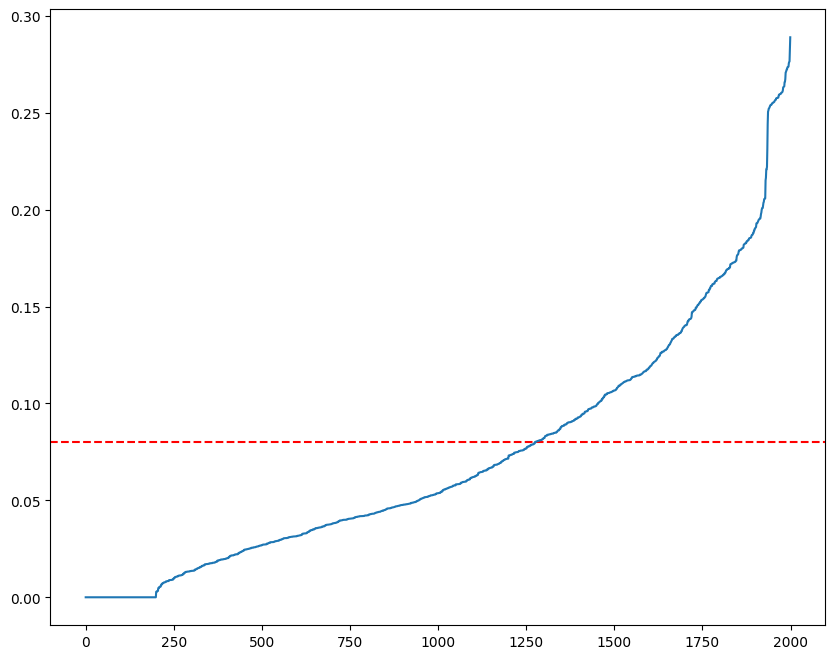

In [ ]:
neigh = NearestNeighbors(n_neighbors = 10,metric='precomputed')
nbrs = neigh.fit(X)
distancias, indices = nbrs.kneighbors(X)
distancias = np.sort(distancias.flatten())
fig=plt.figure(figsize=(10,8), dpi= 100, facecolor='w', edgecolor='k')
plt.axhline(y = 0.08, color = 'r', linestyle = '--')
plt.plot(distancias)

In [ ]:
i = np.arange(len(distancias))
knee = KneeLocator(i, distancias, S=1, curve='convex', direction='increasing', interp_method='polynomial')

print(distancias[knee.knee])

0.119333655


In [ ]:
# Crear un modelo DBSCAN
db = DBSCAN(eps=0.5, min_samples=8)
clusters=db.fit_predict(X)

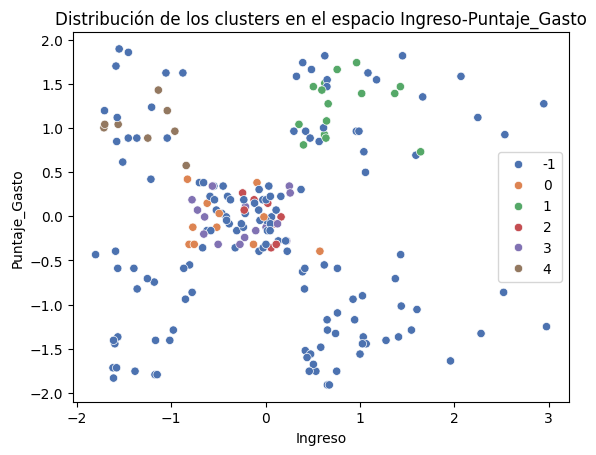

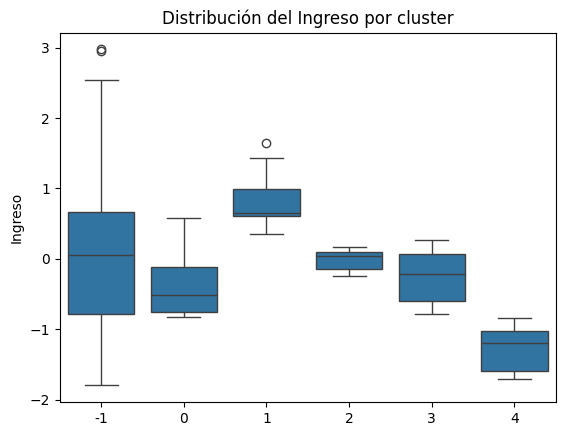

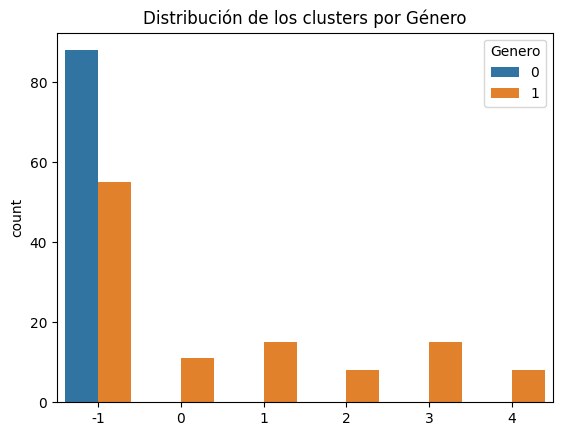

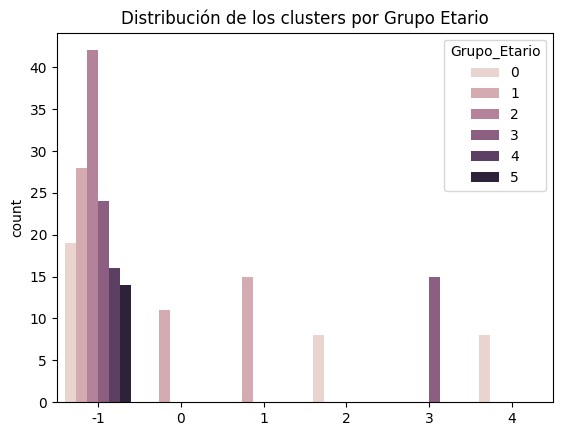

In [ ]:
# Gráfico de dispersión con color por cluster
sns.scatterplot(x='Ingreso', y='Puntaje_Gasto', hue=clusters, data=datos_estandarizados2, palette='deep')
plt.title('Distribución de los clusters en el espacio Ingreso-Puntaje_Gasto')
plt.show()

# Gráfico de cajas para 'Ingreso' por cluster
sns.boxplot(x=clusters, y='Ingreso', data=datos_estandarizados2)
plt.title('Distribución del Ingreso por cluster')
plt.show()

# Gráfico de barras para la distribución de los clusters por género
sns.countplot(x=clusters, hue='Genero', data=datos_estandarizados2)
plt.title('Distribución de los clusters por Género')
plt.show()

# Gráfico de barras para la distribución de los clusters por grupo etario
sns.countplot(x=clusters, hue='Grupo_Etario', data=datos_estandarizados2)
plt.title('Distribución de los clusters por Grupo Etario')
plt.show()

***Procedimiento***

Como primer paso, se creo una base de datos incluyendo las variables Ingresos y Puntaje_Gastos previamente estandarizadas y las variables Genero y Grupo_Etario. Posterior a esto, se realizó la codificación de las variables categoricas empleando la función LabelEncoder(). Posteriormente se caclculó la matriz de distancias empleando como métrica "Gower" y con base en esta se dterminó el mejor valor de eps. Posterior a esto se creó el modelo DBSCAN y se graficaron los resultados analizando la agrupación de los indivudos con cada una de las variables analizadas.

***Análisis y conclusiones***

Se determinó que la mejor eps era de 0,12, sin embargo con estos valores no se observarona agrupaciones, por tanto se dejó la misma distancia calculada en el numeral anterio (0,5) y un número de vecinos igual a 8. Con estos parámetros se generaron 4 clusters, en los que se observan que las principales difernecias se deben principalmente a los Ingresos y al Grupo Etario.